In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
import scikitplot as skplt
from sklearn import preprocessing
import time
from scipy import stats
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('paysim.csv')

In [3]:
print(raw_data.describe())
print(raw_data.head())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [4]:
#rename columns
df = raw_data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [6]:
#modification for step feature
df['step'] = df['step'] % 24

In [7]:
#drop feature irrelevant
df.drop(['nameOrig', 'nameDest'], axis = 1, inplace = True)

In [8]:
#get feature values 
df = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]

In [10]:
#one hot encoding feature type
from sklearn.preprocessing import OrdinalEncoder
typeTrans = [['CASH_OUT'] , ['TRANSFER']]
oencoder = OrdinalEncoder()
oencoder.fit(typeTrans)
df['type_en'] = oencoder.transform(df['type'].values.reshape(-1,1))

In [11]:
df

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_en
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,0,1.0
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,0,0.0
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,0,0.0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,0,1.0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
6362615,23,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0,0.0
6362616,23,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0,1.0
6362617,23,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,0.0
6362618,23,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,1.0


In [12]:
df.drop(['type'], axis = 1, inplace = True)

In [13]:
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_en
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1.0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,0.0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,0.0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1.0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1.0


In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [73]:
test = SelectKBest(score_func = f_classif, k= 3)

In [289]:
y = df['isFraud']
X = df.drop(['isFraud', 'oldBalanceDest', 'type_en', 'newBalanceDest', 'isFlaggedFraud'], axis = 1)
#X = df.drop(['isFraud'], axis = 1)

In [290]:
fit = test.fit(df.drop(['isFraud'], axis = 1), df['isFraud'])
print(fit.scores_)
features = fit.transform(df.drop(['isFraud'], axis = 1))
print(features[0:5,:])

[7.29001755e+03 1.39016379e+04 3.80694276e+05 1.12365491e+04
 6.20175363e+02 2.23308306e+02 5.39161938e+03 4.98958834e+03]
[[1.8100000e+02 1.8100000e+02 0.0000000e+00]
 [1.8100000e+02 1.8100000e+02 0.0000000e+00]
 [2.2913394e+05 1.5325000e+04 0.0000000e+00]
 [2.1531030e+05 7.0500000e+02 0.0000000e+00]
 [3.1168589e+05 1.0835000e+04 0.0000000e+00]]


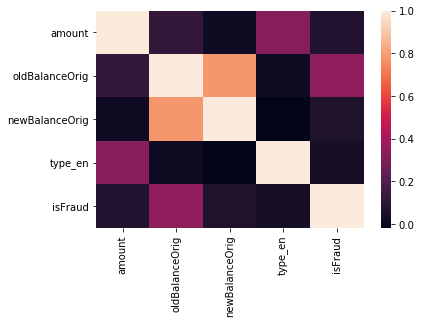

In [91]:
sns.heatmap(pd.concat([X, y], axis = 1).corr())

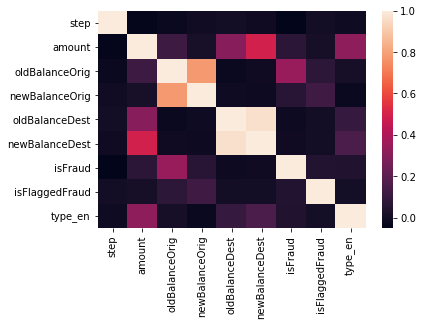

In [49]:
sns.heatmap(df.corr())

In [291]:
X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, random_state = 123, test_size = 0.1)

In [402]:
# define resampling
over = SMOTE(random_state = 123, sampling_strategy = 0.008)
under = RandomUnderSampler(random_state = 123, sampling_strategy = 0.5)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])
#pipeline = Pipeline(steps=[('o', over)])

In [403]:
# fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
print(np.unique(y_resampled, return_counts = True))
pd.DataFrame(X_resampled)

(array([0, 1], dtype=int64), array([39774, 19887], dtype=int64))


,step,amount,oldBalanceOrig,newBalanceOrig
0,9,1.766410e+05,5.900000e+02,0.0
1,19,5.026281e+04,0.000000e+00,0.0
2,15,1.357167e+05,1.005290e+05,0.0
3,9,4.196246e+05,1.765600e+04,0.0
4,9,1.427580e+05,2.182800e+04,0.0
...,...,...,...,...
59656,4,2.501094e+04,2.501094e+04,0.0
59657,3,1.467403e+05,1.467403e+05,0.0
59658,1,5.055802e+05,5.055802e+05,0.0
59659,18,3.890899e+06,3.890899e+06,0.0


In [571]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

imba_pipeline = make_pipeline(SMOTE(random_state = 123, sampling_strategy = 0.008), RandomUnderSampler(random_state = 123, sampling_strategy = 0.5),
                              PowerTransformer(), GaussianNB())
hasil_awal = cross_validate(imba_pipeline, X_train_res, y_train_res, scoring=scoring, cv=cv_method)

In [573]:
hasil_awal_df = pd.concat([pd.DataFrame(hasil_awal["test_accuracy"], columns=["accuracy"]), pd.DataFrame(hasil_awal["test_precision"], columns=["precision"]), pd.DataFrame(hasil_awal["test_recall"], columns=["recall"]), pd.DataFrame(hasil_awal["test_f1"], columns=["f1"]), pd.DataFrame(hasil_awal["test_auc"], columns=["auc"]), pd.DataFrame(hasil_awal["test_specificity"], columns=["specificity"])],axis=1)

In [575]:
hasil_awal_df['fpr'] = 1- hasil_awal_df['specificity']

In [576]:
hasil_awal_df.describe()

,accuracy,precision,recall,f1,auc,specificity,fpr
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.884582,0.021901,0.870767,0.042726,0.946522,0.884623,0.115377
std,0.003460,0.000704,0.009125,0.001345,0.005249,0.003467,0.003467
min,0.876140,0.020213,0.856174,0.039499,0.929692,0.876183,0.107257
25%,0.882985,0.021532,0.863297,0.042017,0.943949,0.883021,0.113317
50%,0.884809,0.021992,0.869064,0.042911,0.947163,0.884875,0.115125
75%,0.886644,0.022291,0.873813,0.043467,0.949980,0.886683,0.116979
max,0.892699,0.023690,0.896739,0.046135,0.954705,0.892743,0.123817


In [404]:
pt = PowerTransformer().fit(X_resampled)
X_train = pt.transform(X_resampled)

In [417]:
gnb = GaussianNB().fit(X_train, y_resampled)
pred1 = gnb.predict(X_train)
print('accuracy score = ', accuracy_score(y_resampled, pred1))
print('precision score = ', precision_score(y_resampled, pred1,average = 'micro'))
print('recall score = ', recall_score(y_resampled, pred1))
print('f1 score = ', f1_score(y_resampled, pred1))
print('roc auc score = ', roc_auc_score(y_resampled, pred1))
cm = confusion_matrix(y_resampled, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity : ', specificity1)

accuracy score =  0.8851008196309147
precision score =  0.8851008196309147
recall score =  0.8751445668024338
f1 score =  0.835465520965845
roc auc score =  0.8826117564237945
Specificity :  0.8900789460451551


In [406]:
pd.DataFrame(cm)

,0,1
0,35402,4372
1,2483,17404


In [407]:
gnb.sigma_

array([[0.65226119, 0.58632136, 0.70912042, 1.32143749],
       [1.35081745, 1.52110589, 0.23316091, 0.29665013]])

In [408]:
scoring = {'accuracy' : 'accuracy', 'precision' : 'precision', 'recall' : 'recall', 'f1' : 'f1', 'auc' : 'roc_auc' , 'specificity' : make_scorer(recall_score, pos_label=0)}

In [409]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state = 123)

In [533]:
time_start = time.time()
np.random.seed(999)

#gb = GaussianNB()

params = {"classifier__priors": [None, [0.5,0.5], [0.6,0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]],
              "classifier__var_smoothing": np.logspace(0, -9)}

#params_NB = {'priors': [None, [0.5,0.5], [0.6,0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]], 'var_smoothing':np.logspace(0, -9)}
imba_pipeline2 = Pipeline([('smote', SMOTE(random_state = 123, sampling_strategy = 0.008)), 
                           ('under', RandomUnderSampler(random_state = 123, sampling_strategy = 0.5)),
                           ('pt', PowerTransformer()),
                           ('classifier', GaussianNB())])


gs_NB2 = RandomizedSearchCV(imba_pipeline2, 
                     param_distributions=params, 
                     cv=cv_method,
                     n_iter = 100,
                     verbose=1, 
                     scoring=scoring, refit = 'recall')


#X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
#X_transformed = PowerTransformer().fit_transform(X_resampled)

gs_NB2.fit(X_train_res, y_train_res)
time_elapsed = (time.time() - time_start)
print(time_elapsed)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 118.6min finished


7124.190348625183


In [534]:
result2 = pd.concat([pd.DataFrame(gs_NB2.cv_results_["params"]),pd.DataFrame(gs_NB2.cv_results_["mean_test_accuracy"], columns=["mean_accuracy"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_precision"], columns=["mean_precision"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_recall"], columns=["mean_recall"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_f1"], columns=["mean_f1"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_auc"], columns=["mean_auc"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_specificity"], columns=["mean_specificity"])],axis=1)

In [577]:
result2['mean_fpr'] = 1 - result2['mean_specificity']

In [578]:
print(gs_NB2.best_params_)
result2.describe()

{'classifier__var_smoothing': 0.0062505519252739694, 'classifier__priors': [0.5, 0.5]}


,classifier__var_smoothing,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.537541e-02,0.897370,0.032396,0.825654,0.060910,0.946426,0.897583,0.102417
std,1.502283e-01,0.054343,0.020860,0.093390,0.035822,0.000544,0.054762,0.054762
min,1.000000e-09,0.796897,0.013400,0.552902,0.026419,0.942500,0.796496,0.011800
25%,3.406209e-07,0.861525,0.018569,0.781247,0.036371,0.946513,0.861462,0.058179
50%,2.559548e-05,0.900068,0.024726,0.852764,0.048058,0.946522,0.900208,0.099792
75%,3.035751e-03,0.941346,0.038314,0.882663,0.073042,0.946522,0.941821,0.138538
max,1.000000e+00,0.986913,0.121987,0.937442,0.199846,0.947257,0.988200,0.203504


In [537]:
result2['classifier__var_smoothing'].unique()

array([3.39322177e-02, 2.32995181e-09, 5.17947468e-02, 1.84206997e-01,
       2.68269580e-03, 7.54312006e-04, 5.42867544e-09, 1.09854114e-05,
       1.26485522e-08, 8.28642773e-09, 1.93069773e-08, 5.96362332e-05,
       7.90604321e-02, 1.67683294e-05, 4.94171336e-04, 2.02358965e-06,
       3.55648031e-09, 3.72759372e-07, 4.29193426e-01, 3.08884360e-06,
       2.12095089e-04, 6.25055193e-03, 2.55954792e-05, 4.09491506e-03,
       7.19685673e-06, 1.00000000e+00, 1.04811313e-07, 2.81176870e-01,
       1.38949549e-04, 9.10298178e-05, 4.49843267e-08, 3.23745754e-04,
       3.90693994e-05, 6.55128557e-01, 1.75751062e-03, 4.71486636e-06,
       2.22299648e-02, 1.45634848e-02, 1.00000000e-09, 5.68986603e-07,
       1.52641797e-09, 1.20679264e-01, 1.59985872e-07, 9.54095476e-03,
       2.44205309e-07, 1.15139540e-03, 1.32571137e-06, 2.94705170e-08])

In [579]:
sortedResult = result2.sort_values(['mean_specificity'], axis = 0, ascending= False).sort_values(['mean_recall'], axis = 0, ascending= False)
sortedResult

,classifier__var_smoothing,classifier__priors,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
71,6.250552e-03,"[0.5, 0.5]",0.802319,0.013842,0.937442,0.027281,0.946479,0.801919,0.198081
84,4.094915e-03,"[0.5, 0.5]",0.802556,0.013857,0.937351,0.027311,0.946492,0.802157,0.197843
57,1.757511e-03,"[0.5, 0.5]",0.802820,0.013876,0.937351,0.027346,0.946510,0.802422,0.197578
95,2.023590e-06,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
19,3.556480e-09,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
...,...,...,...,...,...,...,...,...,...
35,2.811769e-01,"[0.8, 0.2]",0.971347,0.065374,0.653504,0.118848,0.947090,0.972289,0.027711
28,4.094915e-03,"[0.9, 0.1]",0.975282,0.075394,0.653278,0.135173,0.946492,0.976237,0.023763
24,6.250552e-03,"[0.9, 0.1]",0.975483,0.075841,0.651740,0.135857,0.946479,0.976443,0.023557
33,1.000000e+00,None,0.967766,0.057657,0.645226,0.105848,0.942500,0.968722,0.031278


In [580]:
print(sortedResult.to_latex(index = False, caption = "Performansi hasil \textit{tuning parameter} algoritme \textit{gaussian naive bayes}", label = "resGauss"))

\begin{table}
\centering
\caption{Performansi hasil 	extit{tuning parameter} algoritme 	extit{gaussian naive bayes}}
\label{resGauss}
\begin{tabular}{rlrrrrrrr}
\toprule
 classifier\_\_var\_smoothing & classifier\_\_priors &  mean\_accuracy &  mean\_precision &  mean\_recall &   mean\_f1 &  mean\_auc &  mean\_specificity &  mean\_fpr \\
\midrule
              6.250552e-03 &         [0.5, 0.5] &       0.802319 &        0.013842 &     0.937442 &  0.027281 &  0.946479 &          0.801919 &  0.198081 \\
              4.094915e-03 &         [0.5, 0.5] &       0.802556 &        0.013857 &     0.937351 &  0.027311 &  0.946492 &          0.802157 &  0.197843 \\
              1.757511e-03 &         [0.5, 0.5] &       0.802820 &        0.013876 &     0.937351 &  0.027346 &  0.946510 &          0.802422 &  0.197578 \\
              2.023590e-06 &         [0.5, 0.5] &       0.803037 &        0.013891 &     0.937351 &  0.027376 &  0.946522 &          0.802639 &  0.197361 \\
              3.556480e-

In [581]:
result2[ (result2['mean_recall'] >= 0.9)].sort_values(['mean_recall'], axis = 0, ascending= False)

,classifier__var_smoothing,classifier__priors,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
71,6.250552e-03,"[0.5, 0.5]",0.802319,0.013842,0.937442,0.027281,0.946479,0.801919,0.198081
84,4.094915e-03,"[0.5, 0.5]",0.802556,0.013857,0.937351,0.027311,0.946492,0.802157,0.197843
57,1.757511e-03,"[0.5, 0.5]",0.802820,0.013876,0.937351,0.027346,0.946510,0.802422,0.197578
1,2.329952e-09,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
16,1.264855e-08,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
98,2.947052e-08,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
19,3.556480e-09,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
97,3.727594e-07,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
95,2.023590e-06,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361
36,5.428675e-09,"[0.5, 0.5]",0.803037,0.013891,0.937351,0.027376,0.946522,0.802639,0.197361


In [540]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

imba_pipeline = make_pipeline(SMOTE(random_state = 123, sampling_strategy = 0.008), RandomUnderSampler(random_state = 123, sampling_strategy = 0.5),
                              PowerTransformer(), GaussianNB([0.5,0.5],  0.0062505519252739694))
hasil = cross_validate(imba_pipeline, X_train_res, y_train_res, scoring=scoring, cv=cv_method)

In [542]:
hasil_df = pd.concat([pd.DataFrame(hasil["test_accuracy"], columns=["accuracy"]), pd.DataFrame(hasil["test_precision"], columns=["precision"]), pd.DataFrame(hasil["test_recall"], columns=["recall"]), pd.DataFrame(hasil["test_f1"], columns=["f1"]), pd.DataFrame(hasil["test_auc"], columns=["auc"]), pd.DataFrame(hasil["test_specificity"], columns=["specificity"])],axis=1)

In [582]:
hasil_df['fpr'] = 1-hasil_df['specificity']
hasil_df.describe()

,accuracy,precision,recall,f1,auc,specificity,fpr
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.802319,0.013842,0.937442,0.027281,0.946479,0.801919,0.198081
std,0.004716,0.000365,0.008360,0.000710,0.005276,0.004725,0.004725
min,0.792931,0.013014,0.922659,0.025665,0.929529,0.792546,0.188652
25%,0.799201,0.013654,0.932497,0.026918,0.943942,0.798767,0.194538
50%,0.802723,0.013864,0.937585,0.027327,0.947055,0.802311,0.197689
75%,0.805844,0.014083,0.942673,0.027749,0.949861,0.805462,0.201233
max,0.811741,0.014623,0.957880,0.028801,0.954541,0.811348,0.207454


In [584]:
# fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
pt = PowerTransformer().fit(X_resampled)
X_train = pt.transform(X_resampled)
gnb = GaussianNB([0.5,0.5],  6.250552e-03).fit(X_train, y_resampled)
pred1 = gnb.predict(X_train)

In [585]:
print('accuracy score = ', accuracy_score(y_resampled, pred1))
print('precision score = ', precision_score(y_resampled, pred1))
print('recall score = ', recall_score(y_resampled, pred1))
print('f1 score = ', f1_score(y_resampled, pred1))
print('roc auc score = ', roc_auc_score(y_resampled, pred1))
cm = confusion_matrix(y_resampled, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity = ', specificity1)
print('fpr : ', 1-specificity1)

accuracy score =  0.8520474011498299
precision score =  0.7110687022900763
recall score =  0.9367928797707045
f1 score =  0.808470935404778
roc auc score =  0.8732337708050486
Specificity =  0.8096746618393925
fpr :  0.19032533816060748


In [586]:
pd.DataFrame(cm)

,0,1
0,32204,7570
1,1257,18630


In [587]:
X_test

,step,amount,oldBalanceOrig,newBalanceOrig
5848499,18,63925.85,0.0,0.00
6338416,19,115537.04,31000.0,0.00
3627064,10,73175.50,26659.0,0.00
1561811,11,5069.85,302250.0,297180.15
4285299,19,226460.88,102036.0,0.00
...,...,...,...,...
3323609,13,425389.44,0.0,0.00
1273983,15,80709.05,0.0,0.00
3456451,17,659330.38,8575.0,0.00
1907111,22,55469.91,0.0,0.00


In [589]:
X_test_pt = pt.transform(X_test)
pred1 = gnb.predict(X_test_pt)

In [590]:
print('accuracy score = ', accuracy_score(y_test, pred1))
print('precision score = ', precision_score(y_test, pred1))
print('recall score = ', recall_score(y_test, pred1))
print('f1 score = ', f1_score(y_test, pred1))
print('roc auc score = ', roc_auc_score(y_test, pred1))
cm = confusion_matrix(y_test, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity = ', specificity1)
print('fpr : ', 1-specificity1)

accuracy score =  0.8100281185817262
precision score =  0.01465791940018744
recall score =  0.9265402843601895
f1 score =  0.02885928331549618
roc auc score =  0.8681061831218863
Specificity =  0.8096720818835831
fpr :  0.19032791811641692


In [591]:
pd.DataFrame(cm)

,0,1
0,223629,52568
1,62,782


In [592]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    276197
           1       0.01      0.93      0.03       844

    accuracy                           0.81    277041
   macro avg       0.51      0.87      0.46    277041
weighted avg       1.00      0.81      0.89    277041



In [593]:
precision_gauss =  0.01465791940018744
recall_gauss =  0.9265402843601895
f1_gauss =  0.02885928331549618
auc_gauss =  0.8681061831218863
specificity_gauss =  0.8096720818835831
fpr_gauss = 0.19032791811641692

In [594]:
precision_cat =  0.010398016802093376
recall_cat =  0.7156398104265402
f1_cat =  0.020498201316771873
auc_cat =  0.7537565011936754
specificity_cat =  0.7918731919608106
fpr_cat =  0.20812680803918937

In [595]:
auc = [auc_gauss, auc_cat]
recall = [recall_gauss, recall_cat]
f1 = [f1_gauss, f1_cat]
precision = [precision_gauss, precision_cat]
specificity = [specificity_gauss, specificity_cat]
fpr = [fpr_gauss, fpr_cat]

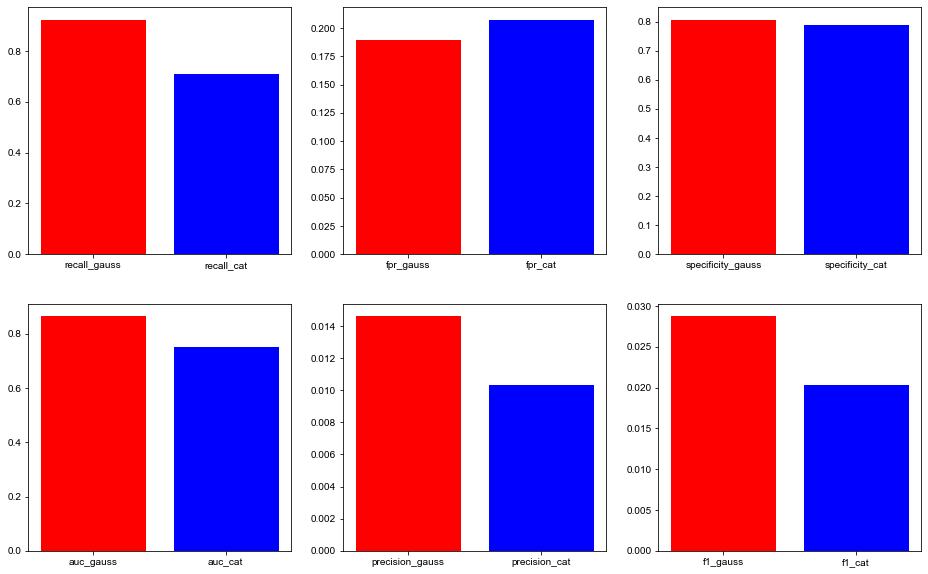

In [596]:
fig, axs = plt.subplots(ncols=3, nrows = 2)
#fig.(figsize= [10,10])
fig.set_figheight(10)
fig.set_figwidth(16)
sns.set(style="darkgrid")

plt.sca(axs[0,0])
plt.bar(['recall_gauss', 'recall_cat'], recall, color = ['red', 'blue'])
#axs[0,0].set_title('mean_accuracy')

plt.sca(axs[0,1])
plt.bar(['fpr_gauss', 'fpr_cat'], fpr, color = ['red', 'blue'])
#axs[1,0].set_title('mean_recall')

plt.sca(axs[0,2])
plt.bar(['specificity_gauss', 'specificity_cat'], specificity, color = ['red', 'blue'])
#axs[1,0].set_title('mean_recall')

plt.sca(axs[1,0])
plt.bar(['auc_gauss', 'auc_cat'], auc, color = ['red', 'blue'])

plt.sca(axs[1,1])
plt.bar(['precision_gauss', 'precision_cat'], precision, color = ['red', 'blue'])
#axs[0,1].set_title('mean_precision')

plt.sca(axs[1,2])
plt.bar(['f1_gauss', 'f1_cat'], f1, color = ['red', 'blue'])
#axs[1,1].set_title('mean_specificity')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')
#    print(ax)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
    
#fig.legend()
fig.savefig('compare')

In [ ]:
fig, axs = plt.subplots()
#fig.(figsize= [10,10])
fig.set_figheight(5)
fig.set_figwidth(8)
sns.set(style="darkgrid")

plt.bar(['auc_gauss', 'auc_cat'], auc, color = ['red', 'blue'])
fig.savefig('compare2')